# Résultats premières expériences

In [1]:
import numpy as np
import os,sys
from graph import *
import copy
import NN,time
from ot_distances import Gromov_Wasserstein_distance,Gromov_distance,Wasserstein_distance
from ts import*

# Toytrees

    - Comment les arbres sont-ils construits ?

Les arbres en question sont des arbres binaires. Ils sont construits de cette manière :
On créé un nombre de feuilles donné, multiple de 2. Les feuilles sont de deux types. Il y a les feuilles dont les attributs sont tirés selon une loi uniforme $\mathcal{U}(0,5)$ et l'autre type de feuille les attributs sont tirés selon une loi uniforme $\mathcal{U}(5,10)$ (ou autres paramètres mais pas de recouvrement).

Ensuite on appareille les feuilles selon deux classes : une classe 0 dans laquelle les feuilles apparaillées proviennent de la même loi uniforme et l'autre classe 1 dans laquelle les feuilles appareillées proviennent des deux lois différents. L'attribut du noeud qui les appareille est la moyenne des atrributs des deux feuilles.

L'objectif est de faire une classification juste sur les feuilles de l'arbre

De cette manière un transport classique va transporter les feuilles d'une même loi sur les feuilles d'une même loi. Dans une classif avec un 1NN on va donc se tromper en gros une fois sur deux (ça dépend du nombre d'arbres aussi dans chaque classe). 



In [2]:
nTree=100
depth=3
c=20
d=30
dataset=build_binary_uniform_dataset(nTree1=nTree,nTree2=nTree,maxdepth=depth,c=c,d=d)
X,y=zip(*dataset)


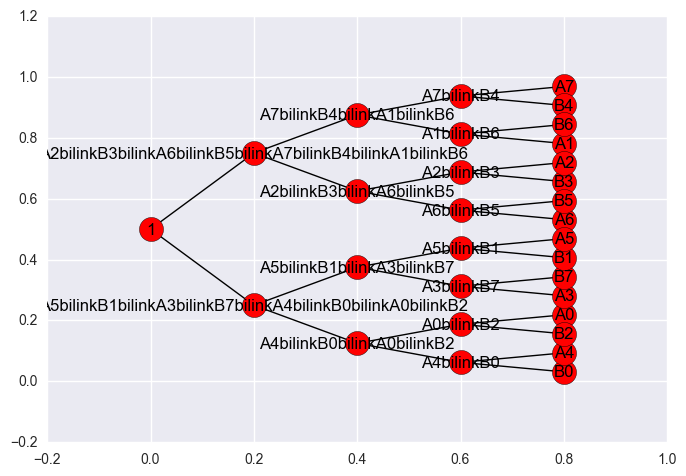

In [5]:
X[0].display_graph(pos=X[0].hierarchy_pos(X[0].nx_graph,1,rotate=True))

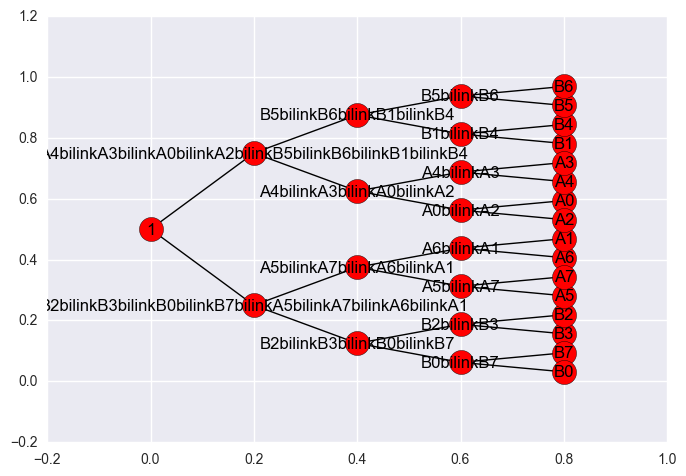

In [7]:
X[101].display_graph(pos=X[101].hierarchy_pos(X[101].nx_graph,1,rotate=True))

## Méthode

J'ai comparé trois approches : EMD classique, l'approche Gromov sans transport sur les features,et l'approche Gromov wasserstein avec transport sur les features. Pour les deux dernières approches j'ai aussi comparé les performances en "normalisant" les distances ($GW(a,b)=2*GW(a,b)-GW(a,a)-GW(b,b)$).

Pour la distance de la structure j'ai considéré le shortest path et aussi ce que j'ai appelé le weighted_shortest_path dans mes paramètres. Si on note $l(i,j)$ le shortest path de $i$ à $j$ et $a(i)$ l'attribut de i. 
Il est défini comme $$C_{i,j}=l(i,j)*\frac{d(a(i),a(j))}{max_{i,j}(d(a(i),a(j))}$$

Pour les distances entre les features j'ai considéré juste la distance euclidienne classique.

Pour les hyperparamètres j'ai fait varier le espilon qui encode la régularisation entropique sur Gromov et Gromov wasserstein et aussi le ration alpha sur epsilon pour le cas Gromov Wasserstein (avec alpha qui fait varier la régularisation lié à la structure). 

Première remarque : dès que ce ratio est un peu plus grand que 2 généralement ça ne converge pas.

Pour comparer les performances j'ai d'abord fait un 5-folds CV sur toute la base. 

Les fichiers result_toytrees_GW.csv, result_toytrees_WGW_parallel.csv et result_toytrees_EMD.csv sur le git présentent tous les résultats dans le détail.

Un notebook Time présente les temps de calculs d'une distance en local sur les jeux de données mutag et toytrees.

Dans le jeux de données il y a 100 arbres de profondeur 3 donc de 16 feuilles.

Voici un résumé :

- EMD : temps de calcul 103 secondes pour un 10 folds CV avec une précision moyenne de 0.53. 

- Gromov : temps de calcul de 30h pour toute la gridsearch, soit 1.5h pour un 5 folds CV. La précision moyenne maximale est de 0.83 pour un gromov normalisé avec comme distance de structure weighted_shortest_path. Le cas du shortest path ne marchait pas je l'avais testé à part. 

- Wasserstein Gromov : temps de calcul de 27h pour toute la gridsearch mais en parallélisant sur les CPU. Le temps de calcul pour un seul 5 CV est à peu près équivalent à Gromov tout court. La meilleure précision moyenne est de 1 et elle est atteinte pour différents jeux de paramètres :  juste shortest_path sans normalisation, ou weighted_shortest_path sans et avec normalisation.. Il n'y a pas réellement de jeu de paramètres vraiment supérieur. 

Cependant lorsqu'on évalue sur un jeu de données test avec 150 arbres (on entraine sur 75% des arbres et on teste les meilleurs modèles sur les 25% restants) on tombe  à une précision de 0.6 en moyenne pour Wasserstein Gromov...



# MUTAG

Le dataset mutag est issu d'un berchmark sur la classification de graph. Deux articles se réfère à ce benchmark "On Valid Optimal Assignment Kernels and Applications to Graph Classification" 2017, Nils M. Kriege et "Weisfeiler-Lehman Graph Kernels" Nino Shervashidze 2011. Les deux méthodes décrites dans les papiers (qui ont l'air d'être un peu 'sate of the art' pour les kernels sur les graphs mais je veux pas trop m'avancer..) obtiennent les meilleures résultats sur ces jeux de données. 

Pour évaluer leurs performances ils répètent 10 fois une 10 CV sur les jeux de données. 

Le jeu de données MUTAG est composé de 188 graphes avec en moyenne 17.93 noeuds par graphe. Il y a deux classes dans le jeu de données : chacune liée à une molécule.

Chaque noeud dispose d'un attribut qualitatif qui est le nom d'un atome, il y a 7 atomes différents possibles dans le jeu de données.

Pour le WL-subtree les auteurs obtiennent 0.82 et pour l'optimal assignment WL kernel 0.86 avec la méthode décrite plus haut.

In [8]:
path='./MUTAG_2/'
dataset=list(build_MUTAG_dataset(path))
X,y=zip(*dataset)

In [10]:
import pandas as pd
pd.Series(y).value_counts()

 1    125
-1     63
dtype: int64

Classe :  1


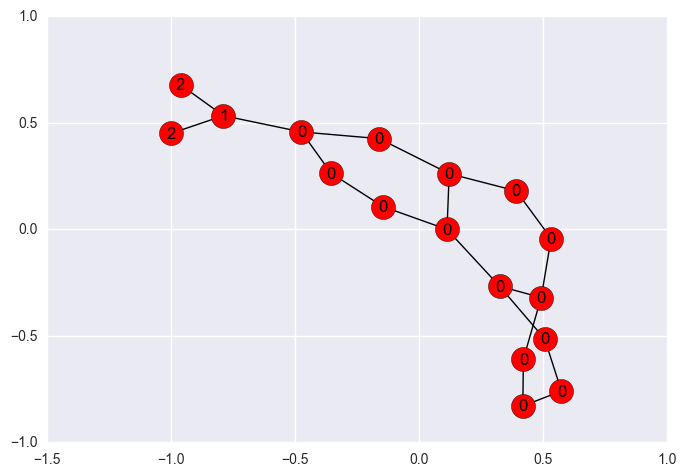

In [14]:
print('Classe : ',y[0])
X[0].display_graph(labels= nx.get_node_attributes(X[0].nx_graph, 'attr_name'))


Classe :  -1


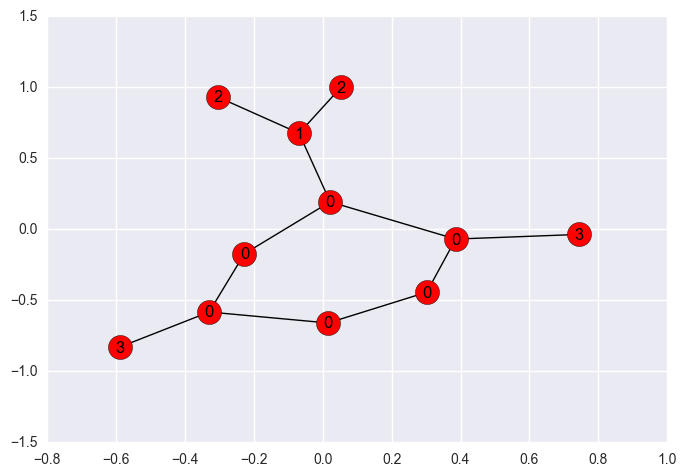

In [17]:
print('Classe : ',y[4])
X[4].display_graph(labels= nx.get_node_attributes(X[4].nx_graph, 'attr_name'))

## Méthode

Je n'ai pas effectué les mêmes tests que les auteurs à cause du temps de calcul.. Je me suis contenté de faire une 5 CV. J'ai effectué la même démarche que pour les toytrees pour la recherche des paramètres. A la différence où comme ce sont des attributs qualitatifs j'ai choisi une distance de type dirac pour les features (0 si différent et 1 si pareil), et pour cette raison je n'ai gardé aussi que la distance shortest_path pour la structure.

Les fichiers result_grid_mutag_EMD.csv,result_grid_mutag_GW.csv et result_grid_mutag_WGW.csv fournissent les détails.

Un résumé :

- EMD : temps de calcul 50 secondes pour un 10 folds CV avec une précision moyenne de 0.76. C'est déjà étonnament assez bon.

- Gromov : temps de calcul de 13h pour toute la gridsearch, soit 30min pour un 5 folds CV. La précision moyenne maximale est aussi de 0.76 pour un gromov normalisé avec comme distance de structure le shortest_path

- Wasserstein Gromov : temps de calcul de 71h pour toute la gridsearch soit 1.4h pour un 5 CV folds. La précision moyenne maximum est de 0.787 pour un gromov wasserstein normalisé